In [1]:


import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:
data = pd.read_csv('C:/Users/utilisateur/2024/E1/data.csv')


In [3]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])



# Split data into training and testing sets
X_train, X_test = train_test_split(numeric_data, test_size=0.2, random_state=42)

X_test_original = X_test.copy()

# Introduce missing values in 10% of the test data
np.random.seed(42)
mask = np.random.rand(*X_test.shape) < 0.1
X_test[mask] = np.nan



In [4]:

class KNNCustomImputer:
    def __init__(self, n_neighbors=8):
        self.n_neighbors = n_neighbors
        self.neighbors = NearestNeighbors(n_neighbors=n_neighbors)
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='mean')
    
    def fit(self, X):
        # Vérification si X est un DataFrame pour gérer les noms de caractéristiques
        if isinstance(X, pd.DataFrame):
            self.feature_names_ = X.columns.tolist()
        else:
            self.feature_names_ = None
        
        # Imputation et mise à l'échelle pour l'ajustement
        X_imputed = self.imputer.fit_transform(X)
        X_scaled = self.scaler.fit_transform(X_imputed)
        self.neighbors.fit(X_scaled)
        
        # Stockage des données d'entraînement imputées et mises à l'échelle pour l'utilisation dans transform
        self.X_train_imputed_scaled_ = X_scaled
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        X_missing = np.isnan(X)
        X_temp_imputed = self.imputer.transform(X)  # Utiliser les statistiques d'imputation apprises lors du fit
        X_scaled = self.scaler.transform(X_temp_imputed)  # Utiliser les statistiques de mise à l'échelle apprises lors du fit
        
        for i in range(X_scaled.shape[0]):
            missing_features = np.where(X_missing[i])[0]
            if missing_features.size > 0:
                distances, neighbors_indices = self.neighbors.kneighbors([X_scaled[i]])
                for feature_index in missing_features:
                    # Utiliser les données d'entraînement imputées et mises à l'échelle pour trouver les valeurs des voisins
                    neighbor_values = self.X_train_imputed_scaled_[neighbors_indices[0], feature_index]
                    X_temp_imputed[i, feature_index] = np.mean(neighbor_values)
        
        # Retourner les données imputées dans le format original
        if self.feature_names_:
            return pd.DataFrame(X_temp_imputed, columns=self.feature_names_)
        return X_temp_imputed

    def fit_transform(self, X):
        return self.fit(X).transform(X)


In [5]:
# Initialisez l'imputer avec le nombre de voisins désiré, par exemple 5
imputer = KNNCustomImputer()

# Entraînez l'imputer sur l'ensemble d'entraînement
imputer.fit(X_train)


In [6]:
# Imputez les valeurs manquantes dans l'ensemble de test
X_test_imputed = imputer.fit_transform(X_test)

X_test_imputed = pd.DataFrame(X_test_imputed, columns=numeric_data.columns)

C:\Users\utilisateur\2024\E1\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [7]:
X_test_imputed 

,ID,Price,Levy,Engine volume,Mileage(km),Cylinders,Airbags,Fuel type_CNG,Fuel type_Diesel,Fuel type_Hybrid,Fuel type_Hydrogen,Fuel type_LPG,Fuel type_Petrol,Fuel type_Plug-in Hybrid
0,4.565604e+07,2509.000000,1399.000000,3.500000,315270.000000,6.0,0.905052,0.000000,0.0,1.000000e+00,0.0,0.0,0.000000,0.000000
1,4.565575e+07,34811.000000,690.000000,3.500000,0.000000,6.0,12.000000,0.000000,0.0,1.000000e+00,0.0,0.0,0.000000,0.000000
2,4.577092e+07,-0.032054,353.000000,1.800000,-0.023714,4.0,12.000000,0.000000,0.0,6.837242e-17,0.0,0.0,0.000000,0.000000
3,1.099474e-01,784.000000,779.000000,2.500000,248570.000000,4.0,12.000000,0.000000,0.0,0.000000e+00,0.0,0.0,1.000000,0.000000
4,1.369185e-01,20491.000000,0.063420,1.600000,50051.000000,4.0,4.000000,0.000000,1.0,0.000000e+00,0.0,0.0,-0.573154,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2553,4.579348e+07,4234.000000,0.131446,2.400000,1500.000000,4.0,0.000000,0.000000,0.0,0.000000e+00,0.0,0.0,1.000000,0.000000
2554,4.580361e+07,24004.000000,862.000000,2.500000,72302.000000,4.0,4.000000,0.000000,1.0,0.000000e+00,0.0,0.0,-0.573154,0.000000
2555,4.578196e+07,26030.000000,0.000000,-0.007043,148800.000000,4.0,8.000000,-0.110710,0.0,1.000000e+00,0.0,0.0,0.000000,-0.051853
2556,4.567476e+07,0.314139,0.000000,1.400000,90000.000000,4.0,8.000000,0.000000,0.0,0.000000e+00,0.0,0.0,0.000000,1.000000


C:\Users\utilisateur\AppData\Local\Temp\ipykernel_17116\501453816.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data_sampled[feature_name], label='Original', fill=True)
C:\Users\utilisateur\AppData\Local\Temp\ipykernel_17116\501453816.py:20: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data_imputed_sampled[feature_name], label='Imputed', fill=True)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


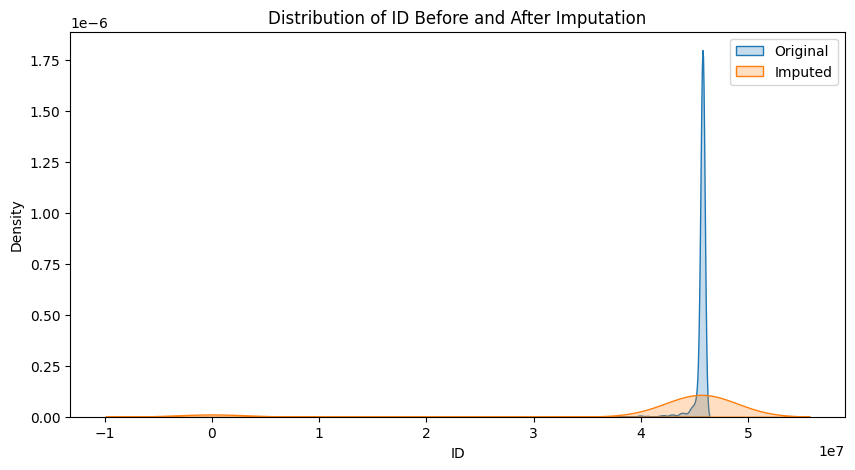

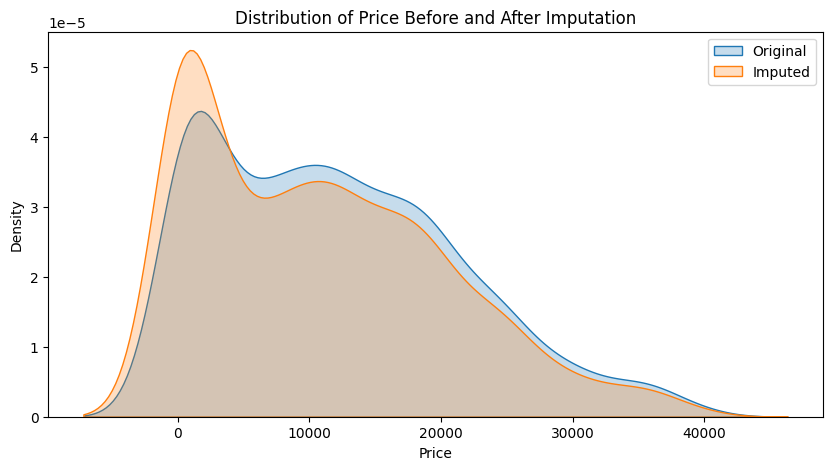

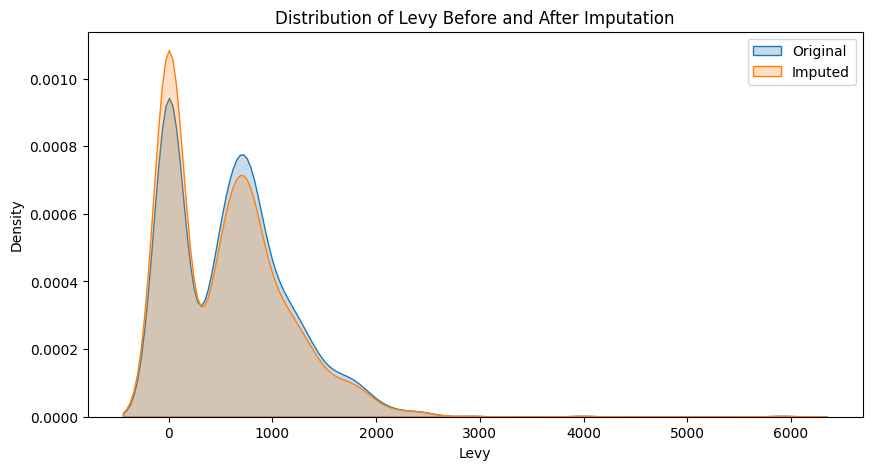

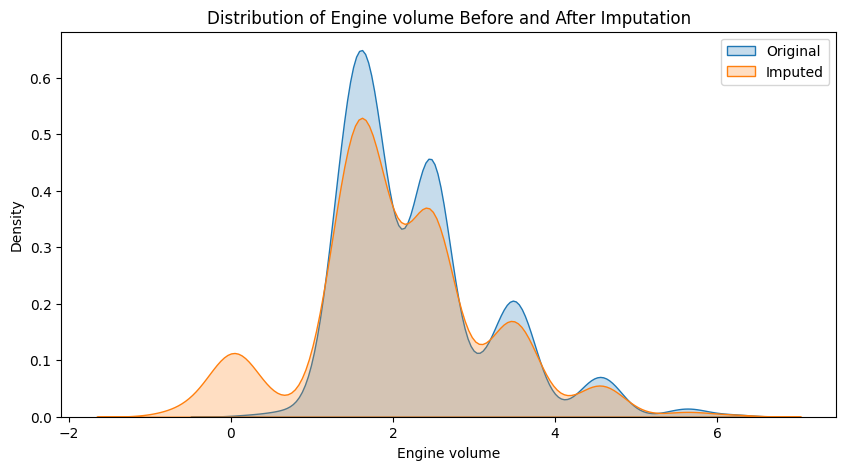

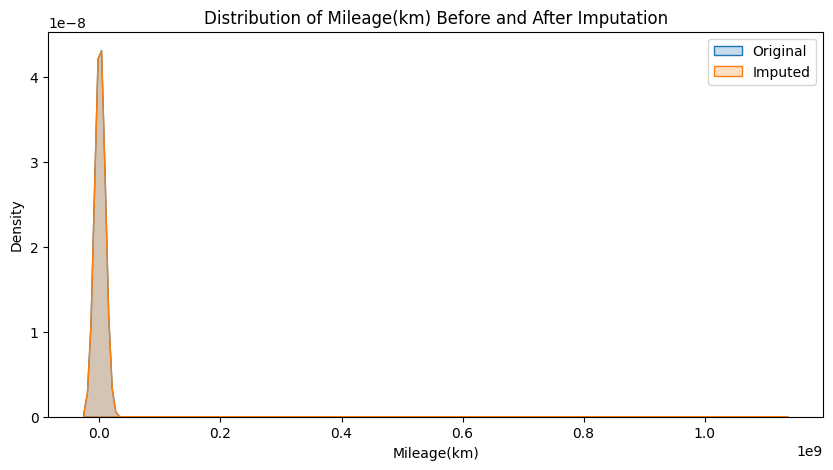

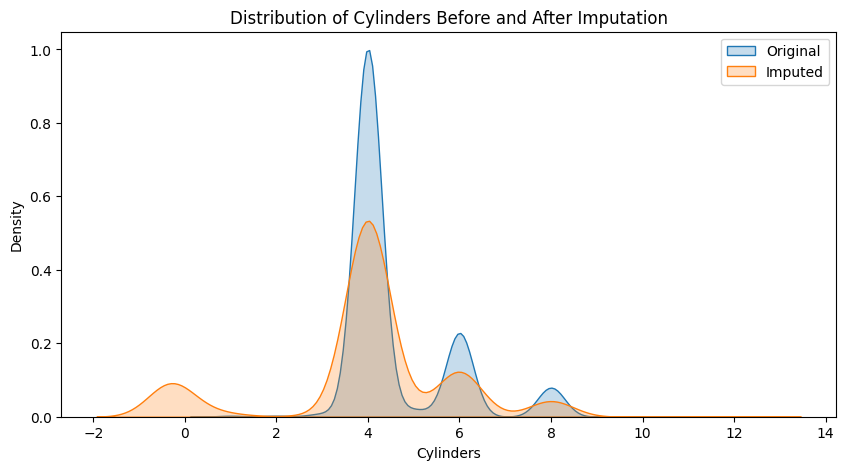

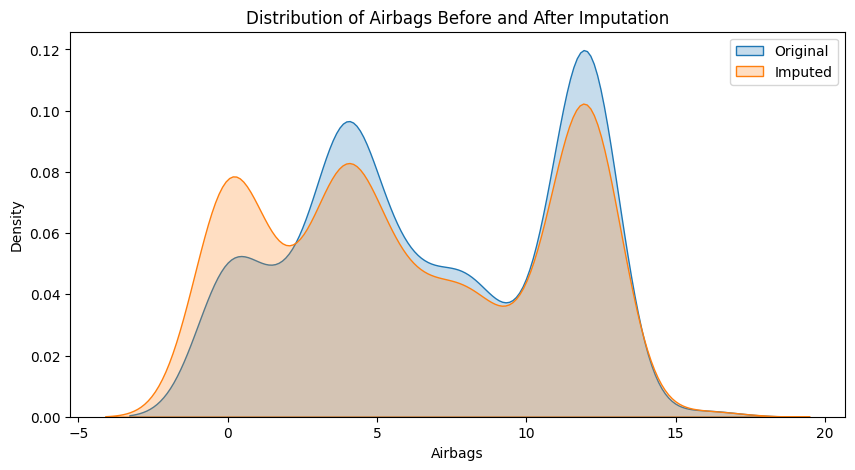

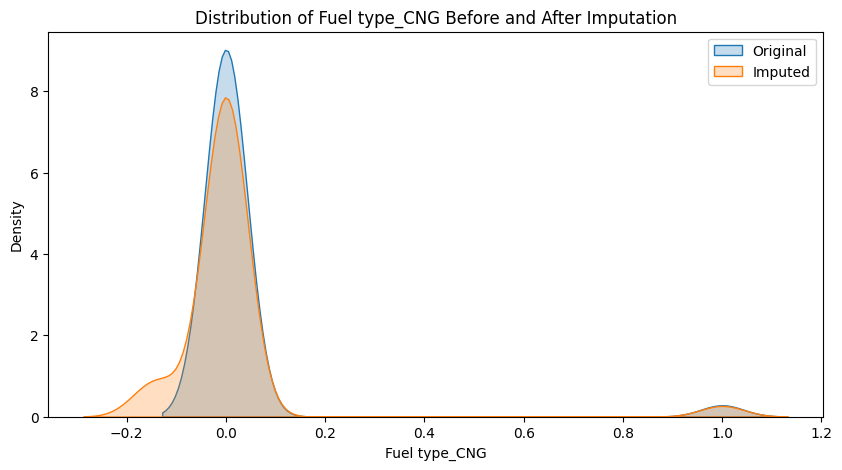

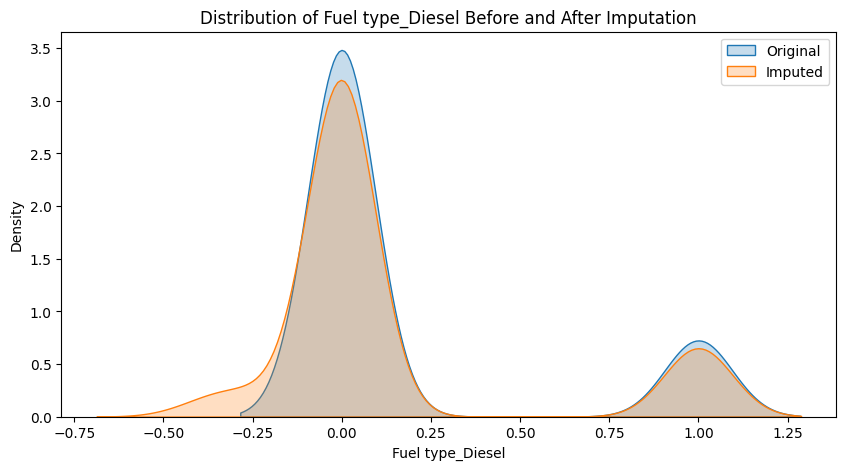

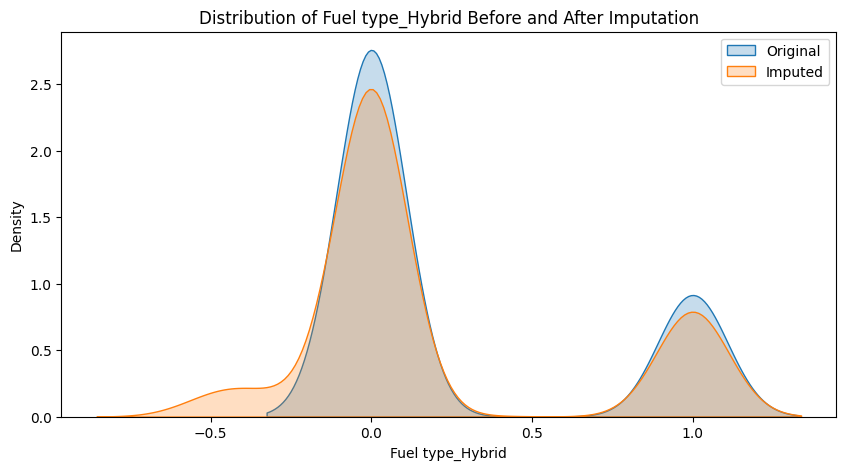

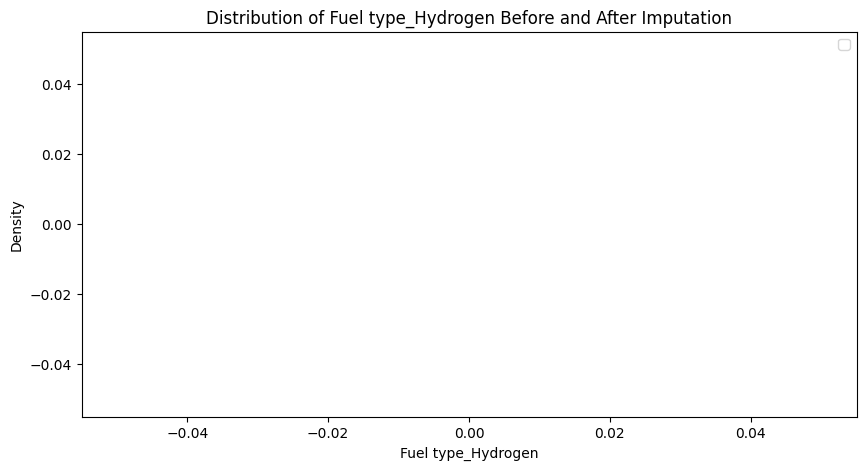

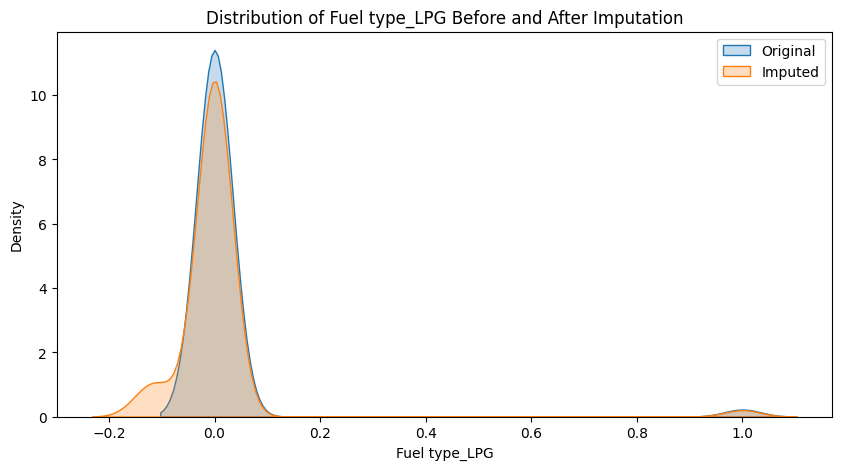

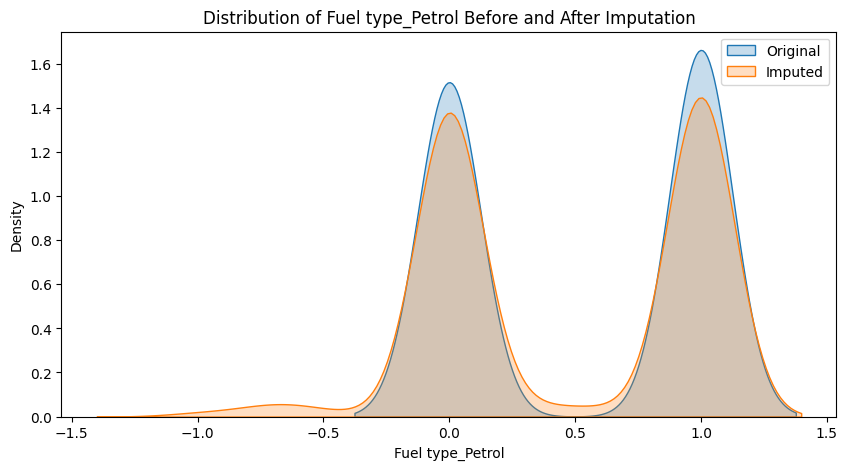

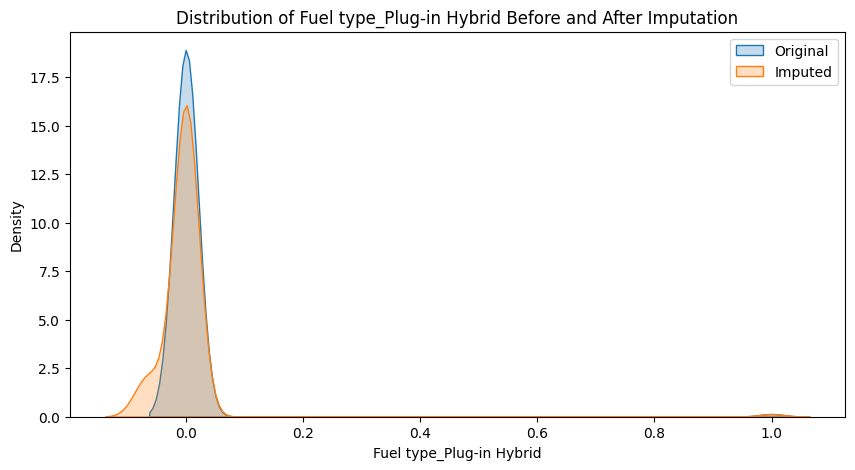

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Randomly sample data for visualization to manage memory usage
sample_size = 1000  # Adjust based on your available memory
indices = np.random.choice(X_test.shape[0], sample_size, replace=False)

# Create a DataFrame for sampled original data
data_sampled = X_test_original.iloc[indices]

# Assuming data_imputed is a DataFrame and has the same index as `data`
data_imputed_sampled = X_test_imputed.iloc[indices]

for col in X_test.columns: 
    
    feature_name = col 
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data_sampled[feature_name], label='Original', fill=True)
    sns.kdeplot(data_imputed_sampled[feature_name], label='Imputed', fill=True)
    plt.title(f'Distribution of {feature_name} Before and After Imputation')
    plt.legend()


In [9]:
# Calculer et comparer les statistiques descriptives avant et après l'imputation
stats_before = X_test_original.describe()
stats_after = pd.DataFrame(X_test_imputed, columns=X_test_original.columns).describe()

print("Statistiques avant imputation:\n", stats_before)
print("\nStatistiques après imputation:\n", stats_after)


Statistiques avant imputation:
                  ID         Price         Levy  Engine volume   Mileage(km)  \
count  2.558000e+03   2558.000000  2558.000000    2558.000000  2.558000e+03   
mean   4.553792e+07  12132.337373   594.023065       2.297263  9.092331e+05   
std    1.160244e+06   9508.743413   572.242336       0.912341  2.681538e+07   
min    2.324298e+07      3.000000     0.000000       0.100000  0.000000e+00   
25%    4.566110e+07   3700.000000     0.000000       1.600000  7.963875e+04   
50%    4.577200e+07  11133.000000   585.000000       2.000000  1.307390e+05   
75%    4.579855e+07  18660.000000   879.500000       2.500000  1.905490e+05   
max    4.581662e+07  39201.000000  5908.000000       6.700000  1.111111e+09   

         Cylinders      Airbags  Fuel type_CNG  Fuel type_Diesel  \
count  2558.000000  2558.000000    2558.000000       2558.000000   
mean      4.582486     6.927287       0.026974          0.160672   
std       1.165951     4.417163       0.162040      

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Supposons que vous ayez stocké les vraies valeurs avant de les masquer dans une variable `true_values`
true_values = X_test_original[mask].values  # Vous devez avoir cette information disponible
imputed_values = X_test_imputed[mask]

# Calcul de l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(true_values, imputed_values)
print("MSE:", mse)

# Calcul de l'erreur absolue moyenne (MAE)
mae = mean_absolute_error(true_values, imputed_values)
print("MAE:", mae)


MSE: 23926218290895.53
MAE: 526226.3894261896


In [11]:
# Enregistrer le modèle en tant que fichier pickle
import pickle

with open("model01.pkl", "wb") as f:
    pickle.dump(imputer, f)


In [17]:
new_data= pd.read_csv('data/loan_data.csv')

In [18]:
new_data


,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


In [19]:
df_numeriques = new_data.drop(columns=new_data.select_dtypes(exclude='number').columns)
    
    # Appliquer le modèle aux données
df_transformed = imputer.fit_transform(df_numeriques)


C:\Users\utilisateur\2024\E1\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [20]:
df_transformed

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1.0,0.1189,829.10,11.350407,19.48,737.0,5639.958333,28854.0,52.1,0.0,0.0,0.0,0.0
1,1.0,0.1071,228.22,11.082143,14.29,707.0,2760.000000,33623.0,76.7,0.0,0.0,0.0,0.0
2,1.0,0.1357,366.86,10.373491,11.63,682.0,4710.000000,3511.0,25.6,1.0,0.0,0.0,0.0
3,1.0,0.1008,162.34,11.350407,8.10,712.0,2699.958333,33667.0,73.2,1.0,0.0,0.0,0.0
4,1.0,0.1426,102.92,11.299732,14.97,667.0,4066.000000,4740.0,39.5,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0.0,0.1461,344.76,12.180755,10.39,672.0,10474.000000,215372.0,82.1,2.0,0.0,0.0,1.0
9574,0.0,0.1253,257.70,11.141862,0.21,722.0,4380.000000,184.0,1.1,5.0,0.0,0.0,1.0
9575,0.0,0.1071,97.81,10.596635,13.09,687.0,3450.041667,10036.0,82.9,8.0,0.0,0.0,1.0
9576,0.0,0.1600,351.58,10.819778,19.18,692.0,1800.000000,0.0,3.2,5.0,0.0,0.0,1.0


In [24]:
stats_original = X_test_original.describe().T[['mean', 'std']]
stats_imputed = X_test_imputed.describe().T[['mean', 'std']]

comparison_stats = pd.concat([stats_original, stats_imputed], axis=1, keys=['Original', 'Imputed'])
comparison_stats

Original                     Imputed  \
                                  mean           std          mean   
ID                        4.553792e+07  1.160244e+06  4.085376e+07   
Price                     1.213234e+04  9.508743e+03  1.089441e+04   
Levy                      5.940231e+02  5.722423e+02  5.384957e+02   
Engine volume             2.297263e+00  9.123412e-01  2.058741e+00   
Mileage(km)               9.092331e+05  2.681538e+07  8.956469e+05   
Cylinders                 4.582486e+00  1.165951e+00  4.075241e+00   
Airbags                   6.927287e+00  4.417163e+00  6.292450e+00   
Fuel type_CNG             2.697420e-02  1.620397e-01  1.088292e-02   
Fuel type_Diesel          1.606724e-01  3.673003e-01  1.121730e-01   
Fuel type_Hybrid          2.412041e-01  4.278975e-01  1.875782e-01   
Fuel type_Hydrogen        0.000000e+00  0.000000e+00  0.000000e+00   
Fuel type_LPG             1.915559e-02  1.370985e-01  6.068318e-03   
Fuel type_Petrol          5.465207e-01  4.979285e-01  4.952328e-01   
Fuel type_Plug-in Hybrid  5.473026e-03  7.379160e-02 -1.321741e-03   

                                        
                                   std  
ID                        1.387599e+07  
Price                     9.662952e+03  
Levy                      5.749311e+02  
Engine volume             1.102392e+00  
Mileage(km)               2.681579e+07  
Cylinders                 1.853484e+00  
Airbags                   4.653903e+00  
Fuel type_CNG             1.625395e-01  
Fuel type_Diesel          3.703426e-01  
Fuel type_Hybrid          4.410812e-01  
Fuel type_Hydrogen        0.000000e+00  
Fuel type_LPG             1.375317e-01  
Fuel type_Petrol          5.241827e-01  
Fuel type_Plug-in Hybrid  7.692632e-02